
# Collecting Data: The Lab.

The goal this week is to use a microcontroller to measure some of the characteristics of a circuit.

The circuit we'll be using is shown in Figure 1, below.

|Figure 1|
|:-|
|![Fig. 1: This Week's Circuit](images/divider.png){fig-align="left" width="557"}||
|This Week's Circuit|

Your instructor will provide your group with a microcontroller and a PCB with this circuit already constructed. You'll be using [CircuitPython](https://circuitpython.org/) to drive the `pin-17` terminal (labelled `Vdac` in the schematic) and collect data from the `pin-15` and `pin-10` terminals (labelled `adc1` and `adc2` in the schematic).

You'll notice that there's a capacitor in the circuit. For the first experiment, we'll drive the circuit very slowly, so that the capacitor plays no role. Later, we'll consider the transient behavior of the circuit and you'll see that the capacitor can have a dramatic effect.

# CircuitPython

[CircuitPython](https://circuitpython.org/) is a version of python that runs on small micro-controllers. It has many of the features of the python language you probably learned before, but it includes libraries that enable one to control and measure voltages on the input and output pins of the micro-controller. To program the microcontroller you'll need to take several steps.

1. Install a microcontroller aware editor on your laptop. I suggest [Thonny](https://thonny.org/). There are others, but thonny is the simplest to install and use.
2. Copy/Paste the "starter code" below into thonny and save "starter.py" to the device.
3. Run the starter code, watch the output window to see the data being collected.
4. Reset the device to see the updated output file.

## 1: Thonny

You can get Thonny [here](https://thonny.org/).

Once you have it installed you can connect the microcontroller and see the port listed as shown in Figure 2.

|Figure 2|
|:-|
|![Fig. 2: Thonny connected to ESP-S2](images/thonny.png){fig-align="left" width="557"}|
|Thonny connected.|



## 2: Starter code

Copy/Paste this code into thonny. Your instructor should step you through the code to explain the bits that are not part of standard python. The non-standard parts are all confined to external libraries (like `board`, and `analogio`.) The idea of this program is to drive the resistor network on the board, and measure the voltages at a couple of test points, giving time for the capacitor to charge between changes.

```
import board # information about the physical microcontroller
import analogio as aio # analog input and output library
import time # standard python time library

ADCMAX = 2**16-1 # maximum input/out from ADC or to DAC

adc1 = aio.AnalogIn(board.IO15)  # to read voltage from pin 15
adc2 = aio.AnalogIn(board.IO10)  # to read voltage from pin 10
vfactor = adc1.reference_voltage/ADCMAX # get conversion factor voltage to pin

vdac = aio.AnalogOut(board.IO17) # to control voltage on pin 17

f = open('starter.csv','w')
header = "j,vdac,v1,v2,time"


vdac.value = 0 # set output voltage to zero
print("sleeping.... let C fully discharge")
print("3")
time.sleep(1)
print("2")
time.sleep(1)
print("1")
time.sleep(1)
print("0 --- go!")

f.write(header + "\n")
print(header)

t0 = time.monotonic_ns()

for i in range(0,255,5): # steps of 5 to save time
    time.sleep(0.4) # let the cap charge....
    t = time.monotonic_ns()-t0
    vout = int((i/255)*ADCMAX)
    vdac.value = vout
    sval = f"{i},{vout*vfactor},{adc1.value*vfactor},{adc2.value*vfactor},{t/1e9}"
    f.write(f"{sval}\n")
    print(sval)

vdac.value = 0 # let the LED rest...
f.close()
```

## 3: Run the code!

You should see an output similar to that shown in Figure 3.

|Figure 3|
|:-|
|![Fig. 3: Start code running](images/starter.png){fig-align="left" width="557"}|
|Starter Code executed.|




## 4: Reset the device

Once the code is complete, you can press the `reset` button on the microcontroller. This will momentarily disconnect and remount the filesystem of the device. Note: the filesystem is mounted "read only" to your computer. This means that you cannot make changes to the filesystem from the file manager of the computer. Only the microcontroller can change the filesystem. Thonny is connected to the microcontroller software, so thonny ask the microcontroller to save updates to the files on the filesystem for you. To see changes to the filesystem from the computer file manager, you need to remount the filesystem, which requires a reset. Once you reset the device you can copy the `csv` file with the measured values to the project folder for analysis.

## 5: Check the data

It's always good to check the data. As an example of just such a check we'll load the sample data from the `data/sample_data` folder and view it. You should save your *real* data in the `data` folder to keep it separate from the data in the `data/sample_data` folder.



In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df_resist = pd.read_csv('data/sample_data/starter2.csv')
df_resist.head()

,j,vdac,v1,v2,time
0,0,0.000000,0.086963,0.058965,0.399872
1,5,0.064656,0.124980,0.060980,0.802948
2,10,0.129361,0.184953,0.087970,1.206210
3,15,0.194067,0.242962,0.124980,1.608860
4,20,0.258773,0.301977,0.164962,2.011350


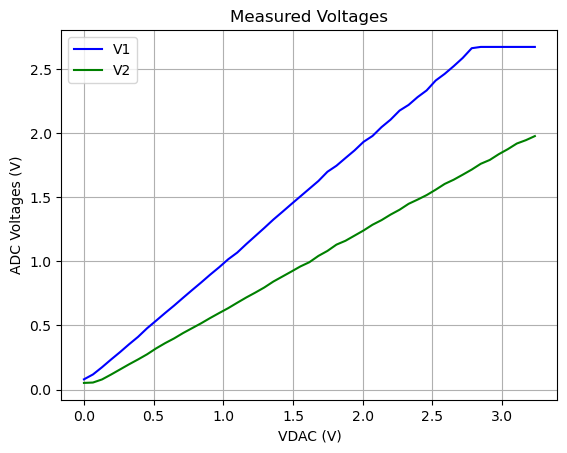

In [4]:
plt.plot(df_resist['vdac'], df_resist['v1'], 'b-', label='V1')
plt.plot(df_resist['vdac'], df_resist['v2'], 'g-', label='V2')
plt.title('Measured Voltages')
plt.xlabel('VDAC (V)')
plt.ylabel('ADC Voltages (V)')
plt.grid()
plt.legend()
plt.show()

## Evaluating the data

What do you notice about this data? There are actually quite a few issues, but we'll discuss them later. The main point here is that you can view the data and assess whether it makes sense very easily. We'll analyze this data in the [CurveFitting](CurveFitting.ipynb) notebook.

## RC Time Constant measurement

The next experiment is to charge the capacitor, and then measure the voltage on the capacitor as it discharges through the parallel combination of the two resistors. The code is prepared for you, but you need to understand it, so go through it carefully.

```
import analogio as aio
import digitalio as dio
import board
import time

ADCMAX = 2**16-1

adc1 = aio.AnalogIn(board.IO13) # analog ports
adc2 = aio.AnalogIn(board.IO15)
adc3 = aio.AnalogIn(board.IO10)
vfactor = adc1.reference_voltage/ADCMAX

dout = dio.DigitalInOut(board.IO17) # digital output
dout.direction = dio.Direction.OUTPUT

f = open('decay.csv','w')
header = "j,v1,v2,v3,time"

data = []

dout.value = 1
print("sleeping.... let C fully charge")
print("3")
time.sleep(1)
print("2")
time.sleep(1)
print("1")
time.sleep(1)
print("0 --- go!")

t0 = time.monotonic_ns()
dout.value = 0

for i in range(0,0xff,0x2): # measure quickly!
    time.sleep(0.001)
    data.append((i,adc1.value, adc2.value, adc3.value, time.monotonic_ns()-t0))

f.write(header + "\n")
print(header)

for i in range(len(data)):
    j,v1,v2,v3,t = data[i]
    sval = f"{j},{v1*vfactor},{v2*vfactor},{v3*vfactor},{t/1e9}"
    f.write(f"{sval}\n")
    print(sval)
    
f.close()
```



In [11]:
df_decay = pd.read_csv('data/sample_data/decay2.csv')
df_decay.head()

,j,v1,v2,v3,time
0,0,0.058965,0.058965,1.96595,0.001984
1,2,0.055995,0.055995,1.90099,0.004028
2,4,0.053980,0.053980,1.84298,0.005859
3,6,0.051966,0.051966,1.78800,0.007660
4,8,0.050959,0.049952,1.73598,0.009491


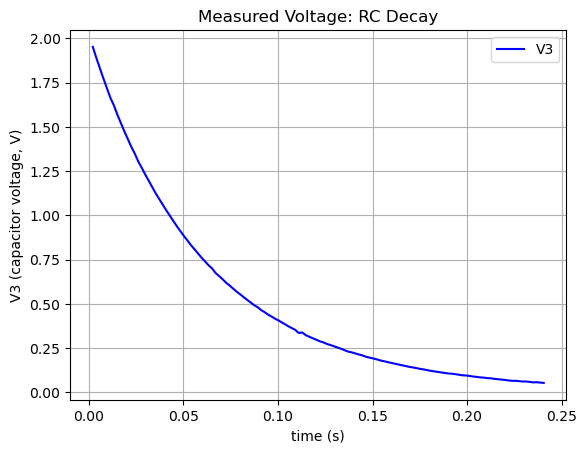

In [10]:
plt.plot(df_decay['time'], df_decay['v3'], 'b-', label='V3')
plt.title('Measured Voltage: RC Decay')
plt.xlabel('time (s)')
plt.ylabel('V3 (capacitor voltage, V)')
plt.grid()
plt.legend()
plt.show()

Clearly this is not linear, so we'll need to find some way to "linearize" it for analysis. More on that soon!